# Flower Classification using VGG


## About VGG

### VGG Block
![](images/VGG/vgg_block.png)

Many convolution layers followed by max pooling

### VGG
![](images/VGG/vgg.png)

Group many vgg blocks together

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as keras
import os
from progressbar import progressbar
import random

2023-07-30 10:44:08.033058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data



In [2]:
class SingleImage:
    def __init__(self):
        self.image_values = None
        self.label = None
        self.id = None

def load_data():
    '''
    Return a list containing Flower objects
    '''
    
    # defind path
    IMAGE_PATH = 'datasets/Flowers'

    # construct id to label dictionary and vice versa
    id2label = {}
    label2id = {}
    id_counter = 0
    for images_folder in os.listdir(IMAGE_PATH):
        if not images_folder.startswith('.'):
            label = images_folder
            id2label[id_counter] = label
            label2id[label] = id_counter
            id_counter += 1
    
    allImages = []
    for image_class in progressbar( os.listdir(IMAGE_PATH) ):
        if not image_class.startswith('.'):
            label = image_class
            id = label2id[label]
            for single_image in os.listdir(os.path.join(IMAGE_PATH, image_class)):
                if not single_image.startswith('.'):
                    temp = SingleImage()
                    temp.id = id
                    temp.label = label
                    temp.image_values = plt.imread(os.path.join(IMAGE_PATH,
                                                                image_class,
                                                                single_image))
                    allImages.append(temp)
    
    random.shuffle(allImages)

    return id2label, label2id, allImages

id2label, label2id, Flowers = load_data()

num_classes = len(id2label)
print(f"{num_classes} different types of flowers")
print(f"Total number of images: {len(Flowers)}")

100% (6 of 6) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


5 different types of flowers
Total number of images: 4317


In [3]:
IMAGE_SHAPE = (224, 224, 3)
IMAGE_SIZE = (224, 224)

In [4]:
def generate_data_array(IMAGE_SIZE, allImages):
    IMAGE_HEIGHT = IMAGE_SIZE[0]
    IMAGE_WIDTH = IMAGE_SIZE[1]
    
    #seperate into tree sets
    trainset = allImages[0 : int(0.6*len(allImages))]
    cvset = allImages[int(0.6*len(allImages)) : int(0.8 * len(allImages))]
    testset = allImages[int(0.8 * len(allImages)) : len(allImages)]
    
    
    # prepare x_train and y_train
    x_train = np.ones((len(trainset) , IMAGE_HEIGHT, IMAGE_WIDTH, 3)) 
    y_train = np.ones( len(trainset) )
    for idx , single_image in progressbar( enumerate(trainset) ):
        img = single_image.image_values
        img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        x_train[idx] = img[:,:,0:3]
        y_train[idx] = single_image.id

    # prepare x_cv and y_cv
    x_cv = np.ones((len(cvset) , IMAGE_HEIGHT, IMAGE_WIDTH, 3))  
    y_cv = np.ones( len(cvset) )
    for idx , single_image in progressbar( enumerate(cvset) ):
        img = single_image.image_values
        img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        x_cv[idx] = img[:,:,0:3]
        y_cv[idx] = single_image.id

    # prepare x_test and y_test
    x_test = np.ones((len(testset) , IMAGE_HEIGHT, IMAGE_WIDTH, 3)) 
    y_test = np.ones( len(testset) )
    for idx , single_image in progressbar( enumerate(testset) ):
        img = single_image.image_values
        img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        x_test[idx] = img[:,:,0:3]
        y_test[idx] = single_image.id
    
    y_train = np.uint8(y_train)
    y_cv = np.uint8(y_cv)
    y_test = np.uint8(y_test)
    
    return x_train, y_train, x_cv, y_cv, x_test, y_test

In [5]:
x_train, y_train, x_cv, y_cv, x_test, y_test = generate_data_array(IMAGE_SIZE, Flowers)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_cv shape: {x_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

/ |#                                                  | 0 Elapsed Time: 0:00:002023-07-30 10:44:17.572139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-30 10:44:17.572186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
| |                                     #          | 2589 Elapsed Time: 0:00:05
| |                   #                             | 862 Elapsed Time: 0:00:01
| |                   #                             | 863 Elapsed Time: 0:00:01


x_train shape: (2590, 224, 224, 3)
y_train shape: (2590,)
x_cv shape: (863, 224, 224, 3)
y_cv shape: (863,)
x_test shape: (864, 224, 224, 3)
y_test shape: (864,)


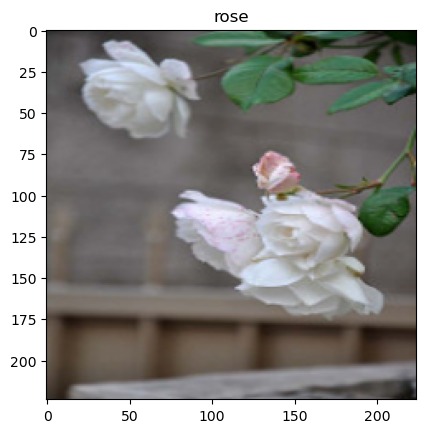

In [6]:
def display_image(rgb, label):
    plt.imshow(np.uint8(rgb))
    plt.title(label)

display_image(x_train[0], id2label[y_train[0]])

In [7]:
# normalize data

x_train = x_train / 255.0
x_cv = x_cv / 255.0
x_test = x_test / 255.0

## Build Model

In [8]:
def vgg_block(num_convs , n_c, conv_kernal_size = 3,
              conv_stride = 1, pooling_kernal_size = 2, 
              pooling_stride = 2):
    
    block = tf.keras.Sequential()
    for _ in range(num_convs):
        conv_layer = tfl.Conv2D(filters = n_c,
                                kernel_size = conv_kernal_size,
                                strides = conv_stride,
                                padding = "same",
                                activation = "relu")
        block.add(conv_layer)
    
    pooling_layer = tfl.MaxPooling2D(pool_size = pooling_kernal_size,
                                    strides = pooling_stride)
    
    block.add(pooling_layer)
    
    return block

In [9]:
def vgg16(IMAGE_SHAPE, arch, num_classes):
    input_image = keras.Input(shape = IMAGE_SHAPE)
    x = input_image
    
    for (num_convs, n_c) in arch:
        block = vgg_block(num_convs, n_c)
        x = block(x)
    
    x = tfl.Flatten()(x)
    x = tfl.Dense(units = 4096, activation = "relu")(x)
    x = tfl.Dense(units = 4096, activation = "relu")(x)
    output = tfl.Dense(units = num_classes, activation = "softmax")(x)
    
    model = keras.Model(inputs = input_image, outputs = output)
    
    return model
    

In [10]:
arch = [(2, 64), (2, 128), (3, 256), (3, 512), (3, 512)]

mymodel = vgg16(IMAGE_SHAPE, arch, num_classes)
mymodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 64)      38720     
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 128)       221440    
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 256)       1475328   
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 512)       5899776   
                                                                 
 sequential_4 (Sequential)   (None, 7, 7, 512)         7079424   
                                                                 
 flatten (Flatten)           (None, 25088)             0     

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

mymodel.compile(optimizer = optimizer, 
                loss = "sparse_categorical_crossentropy", 
                metrics = ["accuracy"])

mymodel.fit(x_train, 
            y_train, 
            epochs = 10,
            batch_size = 64,
            validation_data = (x_cv, y_cv))

Epoch 1/10


2023-07-30 01:08:37.521360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 01:08:37.660462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


41/41 [==============================] - ETA: 0s - loss: 1.9554 - accuracy: 0.2324

2023-07-30 01:09:45.607047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 75s 2s/step - loss: 1.9554 - accuracy: 0.2324 - val_loss: 1.6066 - val_accuracy: 0.2410
Epoch 2/10
41/41 [==============================] - 70s 2s/step - loss: 1.6082 - accuracy: 0.2452 - val_loss: 1.6058 - val_accuracy: 0.2410
Epoch 3/10
41/41 [==============================] - 70s 2s/step - loss: 1.6059 - accuracy: 0.2398 - val_loss: 1.5978 - val_accuracy: 0.2399
Epoch 4/10
41/41 [==============================] - 70s 2s/step - loss: 1.6021 - accuracy: 0.2432 - val_loss: 1.6057 - val_accuracy: 0.2410
Epoch 5/10
41/41 [==============================] - 70s 2s/step - loss: 1.6069 - accuracy: 0.2351 - val_loss: 1.5993 - val_accuracy: 0.2410
Epoch 6/10
41/41 [==============================] - 70s 2s/step - loss: 1.6061 - accuracy: 0.2297 - val_loss: 1.5987 - val_accuracy: 0.2410
Epoch 7/10
41/41 [==============================] - 71s 2s/step - loss: 1.6065 - accuracy: 0.2440 - val_loss: 1.6065 - val_accuracy: 0.2410
Epoch 8/10
41/41 [=============

<Axes: >

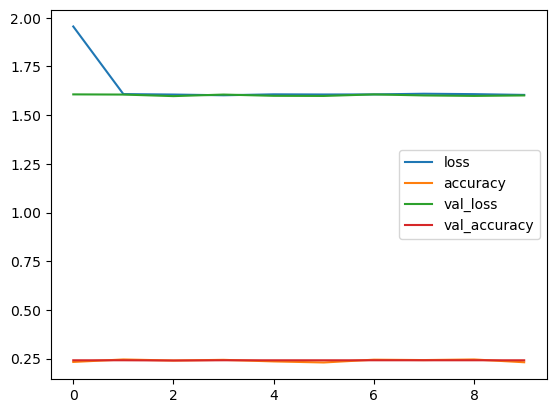

In [12]:
model_loss = pd.DataFrame(mymodel.history.history)
model_loss.plot()

In [13]:
mymodel.evaluate(x_test, y_test)

27/27 [==============================] - 6s 202ms/step - loss: 1.6055 - accuracy: 0.2396


[1.6055272817611694, 0.2395833283662796]

## The accuracy is low, try transfer learning

In [8]:
def tl_vgg16(IMAGE_SHAPE, num_classes, ratio):
    '''
    ratio: the percentage of layers to be unfreezed
    '''
    
    model = keras.Sequential()
    
    # pre_trained model
    pre_trained = keras.applications.vgg16.VGG16(include_top = False, 
                                                 weights = 'imagenet', 
                                                 input_shape = IMAGE_SHAPE)
    
    for idx , layer in enumerate(pre_trained.layers):
        if idx < ((1 - ratio) * len(pre_trained.layers)):
            layer.trainable = False
        else:
            layer.trainable = True
        model.add(layer)
    
    model.add(tfl.Flatten())
    model.add(tfl.Dense(4096, activation = "relu"))
    model.add(tfl.Dense(4096, activation = "relu"))
    model.add(tfl.Dense(num_classes, activation = "softmax"))

    return model
    

In [9]:
mymodel2 = tl_vgg16(IMAGE_SHAPE, num_classes, 0)

In [10]:
mymodel2.summary()
for layer in mymodel2.layers:
    print(layer, end = ' ')
    print(layer.trainable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [11]:
mymodel2.compile(optimizer = 'adam', 
                loss = "sparse_categorical_crossentropy", 
                metrics = ["accuracy"])

mymodel2.fit(x_train, 
            y_train, 
            epochs = 10,
            validation_data = (x_cv, y_cv))

Epoch 1/10


2023-07-30 10:44:46.233168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 10:44:46.279406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


81/81 [==============================] - ETA: 0s - loss: 290.9469 - accuracy: 0.2440

2023-07-30 10:45:05.868793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 26s 308ms/step - loss: 290.9469 - accuracy: 0.2440 - val_loss: 104.1591 - val_accuracy: 0.2851
Epoch 2/10
81/81 [==============================] - 24s 300ms/step - loss: 75.7512 - accuracy: 0.4077 - val_loss: 30.2159 - val_accuracy: 0.4751
Epoch 3/10
81/81 [==============================] - 25s 310ms/step - loss: 66.7299 - accuracy: 0.4691 - val_loss: 106.4829 - val_accuracy: 0.3221
Epoch 4/10
81/81 [==============================] - 24s 302ms/step - loss: 47.5961 - accuracy: 0.5463 - val_loss: 64.5215 - val_accuracy: 0.4612
Epoch 5/10
81/81 [==============================] - 24s 300ms/step - loss: 50.3608 - accuracy: 0.5919 - val_loss: 35.3389 - val_accuracy: 0.6466
Epoch 6/10
81/81 [==============================] - 24s 300ms/step - loss: 22.3543 - accuracy: 0.7282 - val_loss: 21.7255 - val_accuracy: 0.7265
Epoch 7/10
81/81 [==============================] - 24s 300ms/step - loss: 32.8936 - accuracy: 0.6815 - val_loss: 56.5254 - val_accuracy: 

<Axes: >

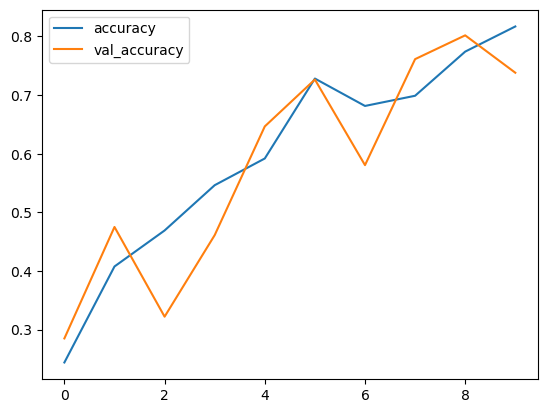

In [17]:
evaluation = {}
evaluation['accuracy'] = mymodel2.history.history['accuracy']
evaluation['val_accuracy'] = mymodel2.history.history['val_accuracy']
model_accuracy = pd.DataFrame(evaluation)
model_accuracy.plot()

In [18]:
mymodel2.evaluate(x_test, y_test)

27/27 [==============================] - 5s 200ms/step - loss: 30.4311 - accuracy: 0.7558


[30.43111801147461, 0.7557870149612427]